# Limber checks using CLASS


In [18]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from classy import Class

from scipy.interpolate import interp1d

# esthetic definitions for the plots
font = {'size'   : 16, 'family':'sans-serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='small'
plt.rcParams["figure.figsize"] = [8.0,6.0]

## Using the Limber approximation calculating the $C_{\ell}^{\delta\kappa}$ integral


\begin{equation}
C_{\ell}^{\delta\kappa} = \frac{\ell(\ell +1)}{(\ell +1/2)^2}\frac{3 H_0^2\Omega_m(0)}{2}\int_{z_f^{\text{min}}}^{z_f^{\text{max}}}\text{d}z n_{\text{HI}}(z)\Sigma(z) (1+z)P_{\delta\delta}\Big[ \frac{\ell+1/2}{\chi(z)},z\Big]\int_{z_b^{\text{min}}}^{z_b^{\text{max}}} \text{d}z'n_{g}(z')\frac{\chi(z') - \chi(z)}{\chi(z)\chi(z')}
\end{equation}

In [ ]:
#####################################################
#
# Cosmological parameters and other CLASS parameters
#
#####################################################


omch2 = 0.12038
ombh2 = 0.022032
h = 0.67556 #H0/100
cspeed = 299792.458 # km/s
A_s = 2.215e-9
n_s = 0.9619
tau_reion = 0.079
neff=3.046

ellmax = 2000
nell   = 400
zmax = 2.0


mu_z1    = 0.8
deltazf = 0.22
#sigma_z1 = 0.1
# redshift bin 2
mu_z2    = 1.2
deltazb = 0.2
#sigma_z2 = 0.1
#
ns = 4.0 # number of sigma in integration
nz = 400 #number of steps to use for the radial/redshift integration


# Define your cosmology (what is not specified will be set to CLASS default parameters)
pars = {
    'output': 'tCl lCl mPk',
    'l_max_scalars': 4000,
    'lensing': 'yes',
    'non linear': 'halofit',
    'omega_b' : ombh2,
    'omega_cdm' : omch2,
    'h' : h,
    'ln10^{10}A_s' : np.log(10**10 *A_s),
    'n_s' : n_s,
    'tau_reio' : tau_reion,
    'N_eff': neff,
    'YHe' : 0.24,
    'N_ncdm' : 0,
    'halofit_k_per_decade' : 3000.,
    'l_switch_limber' : 40.,
    'accurate_lensing':1,
    'num_mu_minus_lmax' : 1000.,
    'delta_l_max' : 1000.,
    'z_max_pk':zmax}

k_max = 1;

#Initialize the cosmology andcompute everything
cosmo = Class()
cosmo.set(pars)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
z = 0.0

#Call these for the nonlinear and linear matter power spectra
#Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])


#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
#k /= h
#Plin *= h**3
#Pnonlin *= h**3


background  = cosmo.get_background()
# comivng distance is in units Mpc
comoving_dist = background['comov. dist.']
ztab = background['z']

# interpolation function of comoving distance
comoving_dist_intp = interp1d(ztab,comoving_dist,kind='cubic')

Hubble = background['H [1/Mpc]']
Hubble_intp = interp1d(ztab,Hubble,kind='cubic')

growth_factor = background['gr.fac. D']
growth_factor_intp = interp1d(ztab,growth_factor,kind='cubic')



deltazf = 0.22;
deltazb = 0.2;
mu_z1 = 0.8;
mu_z2 = 1.2;
z1  = np.linspace(mu_z1-deltazf/2,mu_z1+deltazf/2,num=nz,endpoint=False) # should use better integrator formula
z2  = np.linspace(mu_z2-deltazb/2,mu_z2+deltazb/2,num=nz,endpoint=False)

dz1 = z1[1]-z1[0]
dz2 = z2[1]-z2[0]


ellarr_class = np.linspace(2,ellmax,nell)
resarr_class = np.zeros(np.size(ellarr_class))

for il, ell in enumerate(ellarr_class):
    res_c = 0.0
    for iz in z1:
        chi_iz = comoving_dist_intp(iz) # returns comoving radial distance chi in Mpc
        kz     = (0.5+ell)/chi_iz
        Pkz    = cosmo.pk_lin(kz, iz)
        W_iz = 1/deltazf
        for jz in z2:
            chi_jz = comoving_dist_intp(jz) # returns comoving radial distance chi in Mpc
            W_jz = 1/deltazb
            res_c    = res_c + W_iz*(1.0+iz)*Pkz*W_jz*(chi_jz-chi_iz)/(chi_jz*chi_iz)
    res_c = res_c*(1.0+ell)*ell/(0.5+ell)**2
    res_c = res_c*1.5*(omch2+ombh2)*100.0**2/cspeed**2 # units 1/Mpc^2
    resarr_class[il]=res_c*dz1*dz2
    print(ell,res_c)



# Save results to output file for visualisation elsewhere
np.savez_compressed('cl_cross_limber_usingCLASSfunctions-tophat.npz',l_limber=ellarr_class,cl_limber=resarr_class)



## loading data 

In [29]:

filename = "Data/Limber-zf0.8-zb1.2-deltaz0.22-deltazb0.2_March2022_03_cl.dat"


Cl_data_CLASS_tophat = np.loadtxt(filename)
l= Cl_data_CLASS_tophat[:,0]

Cl_deltakappa_Class_tophat = l*(l+1)*Cl_data_CLASS_tophat[:,8]/(l*(l+1)/(2*np.pi))/2


data_limber_class_tophat = np.load('Data/cl_cross_limber_usingCLASSfunctions-tophat.npz')

l_limber_class_tophat  = data_limber_class_tophat['l_limber']
cl_limber_class_tophat = data_limber_class_tophat['cl_limber']


## plots

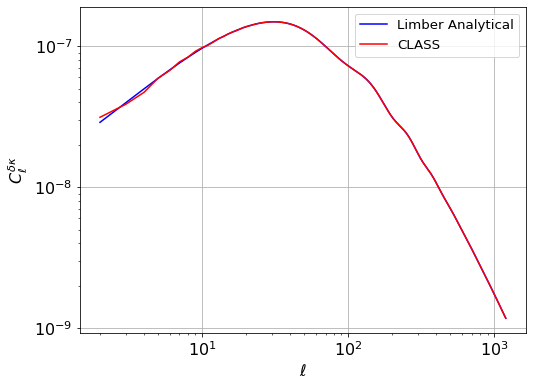

In [32]:
cl_limber_dk_f = interp1d(l_limber_class_tophat,cl_limber_class_tophat,kind='cubic')
cl_limber_dk_intp = cl_limber_dk_f(l)


plt.plot(l,cl_limber_dk_intp,color='b',label=r'Limber Analytical')

plt.plot(l,Cl_deltakappa_Class_tophat,color='r',label=r'CLASS')


plt.xlabel('$\ell$')
plt.ylabel('$C_\ell^{\delta\kappa}$')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')

## relative plot

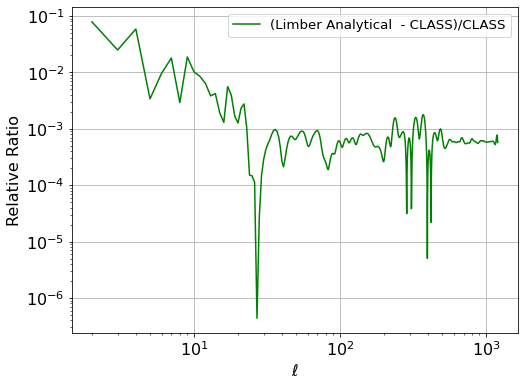

In [33]:

plt.plot(l,np.abs((cl_limber_dk_intp - Cl_deltakappa_Class_tophat)/Cl_deltakappa_Class_tophat),color='g',label=r'(Limber Analytical  - CLASS)/CLASS')


plt.xlabel('$\ell$')
plt.ylabel('Relative Ratio')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')

# $ C^{\delta\delta}_{\ell}$

The code from Mathematica is shown below

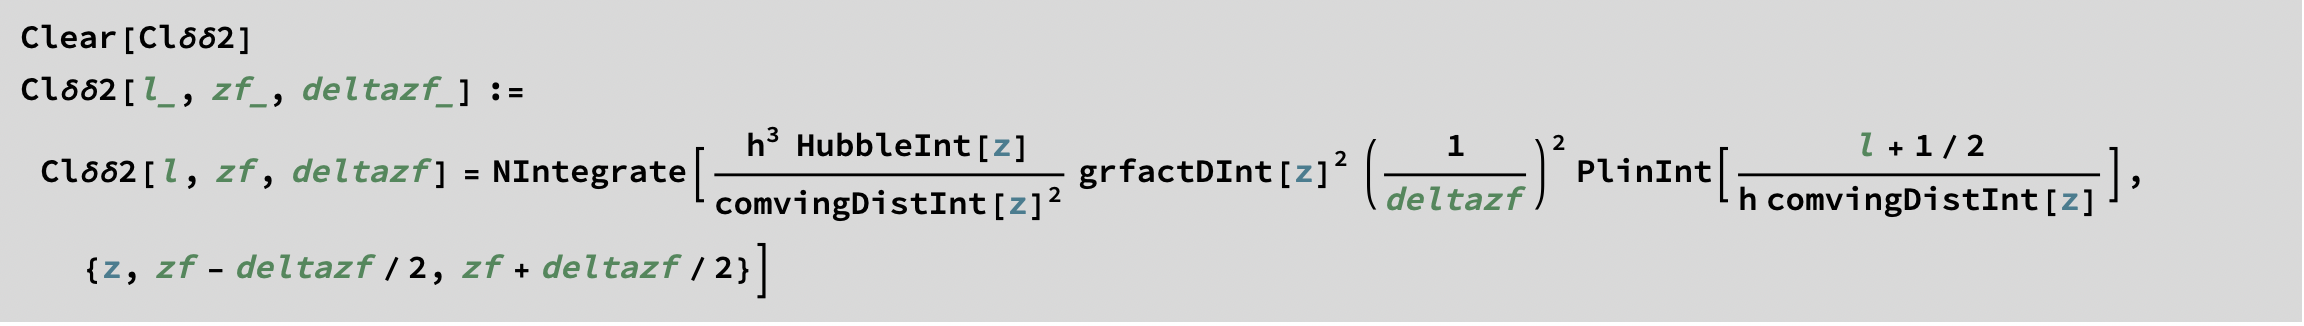

In [42]:
from IPython.display import Image
Image("Data/Cldd-mathematica.png")


In [43]:
import h5py
filename = "Data/Cldd.h5"

# calculated from Mathematica
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    Cl_dd_MATHEMATICA = f['Cldd'][:]
    Cl_dd_CLASS = f['CLASS-Cldd'][:]
    lTab = f['lTab'][:]

Keys: KeysView(<HDF5 file "Cldd.h5" (mode r)>)


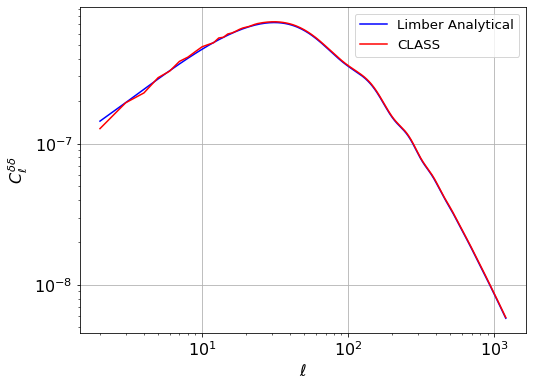

In [39]:

plt.xscale('log')
plt.yscale('log')
plt.plot(lTab,Cl_dd_MATHEMATICA,color='b',label=r'Limber Analytical')

plt.plot(lTab,Cl_dd_CLASS,color='r',label=r'CLASS')


plt.xlabel('$\ell$')
plt.ylabel('$C_\ell^{\delta\delta}$')
plt.legend()
plt.grid()



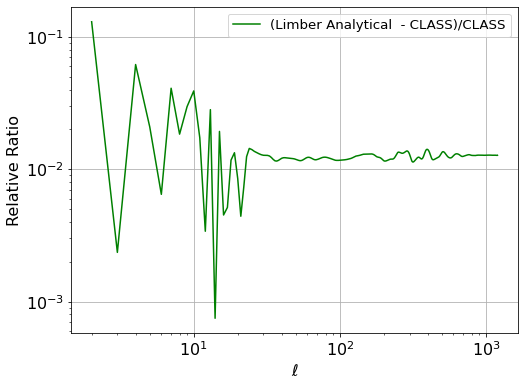

In [40]:
plt.plot(l,np.abs((Cl_dd_MATHEMATICA - Cl_dd_CLASS)/Cl_dd_CLASS),color='g',label=r'(Limber Analytical  - CLASS)/CLASS')


plt.xlabel('$\ell$')
plt.ylabel('Relative Ratio')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')

## Ratio of $C_{\ell}^{\delta \kappa}$ and $C_{\ell}^{\delta \delta}$

(0.19, 0.22)

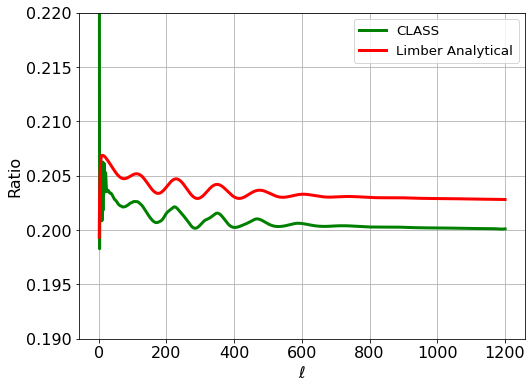

In [50]:

ratio_CLASS_Cldk_Cldd = Cl_deltakappa_Class_tophat / Cl_dd_CLASS

ratio_Cldk_Cldd_analytical = cl_limber_dk_f(l)/Cl_dd_MATHEMATICA


plt.plot(l,(ratio_CLASS_Cldk_Cldd),color='g',label=r'CLASS', linewidth=3)

plt.plot(l,(ratio_Cldk_Cldd_analytical),color='r',label=r'Limber Analytical',linewidth=3)

plt.xlabel('$\ell$')
plt.ylabel('Ratio')
plt.legend()
plt.grid()
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.19,0.22)

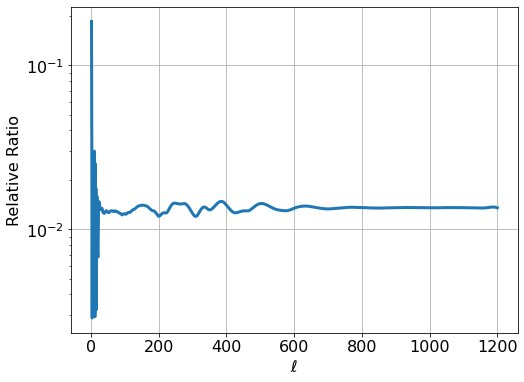

In [51]:
plt.plot(l,np.abs(ratio_Cldk_Cldd_analytical - ratio_CLASS_Cldk_Cldd)/ratio_CLASS_Cldk_Cldd,linewidth=3)

plt.xlabel('$\ell$')
plt.ylabel('Relative Ratio')

plt.grid()
#plt.xscale('log')
plt.yscale('log')

